In [1]:
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.preprocessing import QuantileTransformer, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline

import umap  # pip install umap-learn

# df = pd.read_csv('results/State-Vis-Pretraining/ALE/Pong-v5/Trajectory_visualisations/data.csv')
df = pd.read_csv('results/State-Vis-Pretraining/MiniGrid/BlockedUnlockPickup-v0/Trajectory_visualisations/data.csv')

# Split into X and y
X = df.drop(columns=['Episode', 'Step','y'])  # All columns except 'y'

label_encoder = LabelEncoder()
# Convert string labels to integers
y = label_encoder.fit_transform(df['y'])
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label mapping:", label_mapping)

Label mapping: {'HUMAN_Demos': 0, 'SAC_PEBBLE': 1}


In [2]:
X.head()

,0,1,2,3,4,5,6,7,8,9,...,188,189,190,191,192,193,194,195,196,197
0,2,5,0,2,5,0,2,5,0,2,...,0.0,2.0,5.0,0.0,2.0,5.0,0.0,2.0,5.0,0.0
1,2,5,0,2,5,0,2,5,0,2,...,0.0,2.0,5.0,0.0,2.0,5.0,0.0,2.0,5.0,0.0
2,2,5,0,2,5,0,2,5,0,2,...,0.0,2.0,5.0,0.0,2.0,5.0,0.0,2.0,5.0,0.0
3,2,5,0,2,5,0,2,5,0,2,...,0.0,2.0,5.0,0.0,2.0,5.0,0.0,2.0,5.0,0.0
4,2,5,0,2,5,0,2,5,0,2,...,0.0,2.0,5.0,0.0,2.0,5.0,0.0,2.0,5.0,0.0


In [3]:
# Preprocess again
pipe = make_pipeline(SimpleImputer(strategy="mean"), QuantileTransformer())
X = pipe.fit_transform(X.copy())

In [4]:
# Fit UMAP to processed data
manifold = umap.UMAP().fit(X, y)
X_reduced_2 = manifold.transform(X)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/Users/andreas/miniconda3/envs/xdrl/lib/python3.9/site-packages/umap/spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(


In [5]:
# Fit t-SNE to processed data
tsne = TSNE(n_components=2, random_state=1)
X_tsne = tsne.fit_transform(X)

In [6]:
X_tsne.shape

(1482, 2)

In [7]:
df_umap = pd.DataFrame(X_reduced_2, columns=['UMAP_x', 'UMAP_y'])
df_umap['TSNE_x'] = X_tsne[:,0]
df_umap['TSNE_y'] = X_tsne[:,1]
df_umap['Episode'] = df['Episode']
df_umap['Step'] = df['Step']
df_umap['y'] = df['y']
df_umap


,UMAP_x,UMAP_y,TSNE_x,TSNE_y,Episode,Step,y
0,13.766283,2.451561,-45.176929,77.192345,1_0,0,SAC_PEBBLE
1,8.816266,-19.101040,-74.621201,53.204693,1_0,1,SAC_PEBBLE
2,8.877136,-19.040157,-74.621201,53.204693,1_0,2,SAC_PEBBLE
3,8.774543,-19.142830,-80.630104,55.884808,1_0,3,SAC_PEBBLE
4,13.780579,2.465835,-46.582363,72.620026,1_0,4,SAC_PEBBLE
...,...,...,...,...,...,...,...
1477,3.008169,-0.746085,20.703577,50.137856,1_9,12,HUMAN_Demos
1478,3.002557,-0.499709,17.104645,72.891220,1_9,13,HUMAN_Demos
1479,2.906373,-0.975161,29.010818,45.455990,1_9,14,HUMAN_Demos
1480,3.081670,-0.522965,15.390804,64.129929,1_9,15,HUMAN_Demos


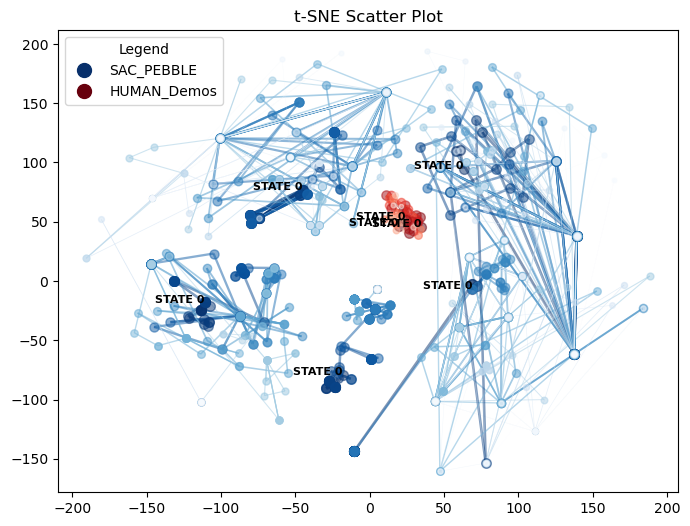

In [12]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.lines as mlines
from matplotlib.collections import LineCollection

dim2D_x = 'TSNE_x'
dim2D_y = 'TSNE_y'

unique_y_values = df_umap['y'].unique()
# Define colors for each unique value of 'y'
# colors = plt.cm.viridis(np.linspace(0, 1, len(unique_y_values)))
# cmap = cm.Blues  
cmap = [cm.Blues.reversed(), cm.Reds.reversed()]  # You can choose other colormaps like 'Greens', 'Purples', etc.

# Plot the results
plt.figure(figsize=(8, 6))
# scatter = plt.scatter(df_umap['UMAP_x'], df_umap['UMAP_y'], c=df_umap['y'], s=0.5, cmap='viridis', label='Data points')

# Prepare a list to store legend handles
legend_handles = []

for i, y_value in enumerate(unique_y_values):
    subset = df_umap[df_umap['y'] == y_value]

    # Create a colormap for each y_value based on Step
    
    norm = plt.Normalize(subset['Step'].min(), subset['Step'].max())  # Normalize Step for this y_value
    
    # Extract the color for the legend from the first Step (or minimum Step)
    first_color = cmap[i](norm(subset['Step'].min()))
    
    # Create a legend handle with the y value and its color
    legend_handles.append(mlines.Line2D([], [], color=first_color, marker='o', linestyle='None', markersize=10, label=str(y_value)))
    
    # Plot scatter points with the same colormap for each y_value
    for _, row in subset.iterrows():
        color = cmap[i](norm(row['Step']))  # Color based on the current Step value
        marker_size = 50 - 40 * (row['Step'] / subset['Step'].max())  # Marker size, thick to thin
        plt.scatter(row[dim2D_x], row[dim2D_y], color=color, s=marker_size, alpha=0.5, zorder = 20)

    # For each 'Episode', plot the lines connecting points from Step 0 to the last Step
    for episode in subset['Episode'].unique():
        episode_data = subset[subset['Episode'] == episode].sort_values('Step')
        
        # Get the coordinates of the first step (Step 0) to annotate "STATE ZERO"
        first_step = episode_data[episode_data['Step'] == 0]
        if not first_step.empty:
            first_step_x = first_step[dim2D_x].values[0]
            first_step_y = first_step[dim2D_y].values[0]
            plt.text(first_step_x, first_step_y, 'STATE 0', fontsize=8, ha='right', color='black', fontweight='bold', zorder = 50)

        # Create line segments between each consecutive point
        segments = []
        colors = []
        linewidths = []

        # Interpolate the color for each segment (shades of blue)
        for j in range(len(episode_data) -1):
            x_vals = episode_data.iloc[j:j+2][dim2D_x].values
            y_vals = episode_data.iloc[j:j+2][dim2D_y].values
            step_vals = episode_data.iloc[j:j+2]['Step'].values

            # Add the segment to segments list
            segments.append([(x_vals[0], y_vals[0]), (x_vals[1], y_vals[1])])

            # Line color based on the current step in the segment (single color gradient)
            color = cmap[i](norm(step_vals[0]))  # Color based on the current step
            # Line thickness: thicker at the beginning (Step 0) and thinner at the end
            linewidth = 2 - 1.9 * (step_vals[0] / episode_data['Step'].max())  # Gradually decreasing thickness
            colors.append(color)
            linewidths.append(linewidth)

        # Create a LineCollection for the segments in this episode
        lc = LineCollection(segments, colors=colors, linewidths=linewidths, alpha=0.5, zorder = 10)
        plt.gca().add_collection(lc)

            # plt.plot(x_vals, y_vals, color=color, linewidth=linewidth, alpha=0.5, zorder = 10)  # Alpha for transparency

# Add title and labels
plt.title('t-SNE Scatter Plot')
# Add custom legend
plt.legend(handles=legend_handles, title="Legend", loc='best')

plt.show()

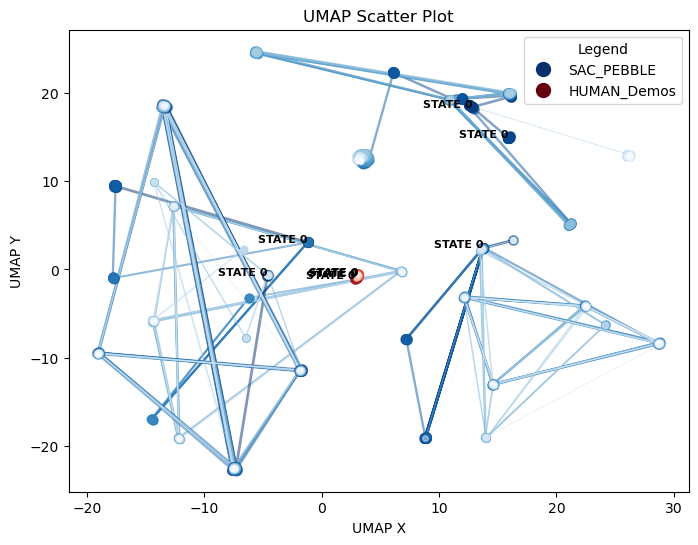

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.lines as mlines
from matplotlib.collections import LineCollection

dim2D_x = 'UMAP_x'
dim2D_y = 'UMAP_y'

unique_y_values = df_umap['y'].unique()
# Define colors for each unique value of 'y'
# colors = plt.cm.viridis(np.linspace(0, 1, len(unique_y_values)))
# cmap = cm.Blues  
cmap = [cm.Blues.reversed(), cm.Reds.reversed()]  # You can choose other colormaps like 'Greens', 'Purples', etc.

# Plot the results
plt.figure(figsize=(8, 6))
# scatter = plt.scatter(df_umap['UMAP_x'], df_umap['UMAP_y'], c=df_umap['y'], s=0.5, cmap='viridis', label='Data points')

# Prepare a list to store legend handles
legend_handles = []

for i, y_value in enumerate(unique_y_values):
    subset = df_umap[df_umap['y'] == y_value]

    # Create a colormap for each y_value based on Step
    
    norm = plt.Normalize(subset['Step'].min(), subset['Step'].max())  # Normalize Step for this y_value
    
    # Extract the color for the legend from the first Step (or minimum Step)
    first_color = cmap[i](norm(subset['Step'].min()))
    
    # Create a legend handle with the y value and its color
    legend_handles.append(mlines.Line2D([], [], color=first_color, marker='o', linestyle='None', markersize=10, label=str(y_value)))
    
    # Plot scatter points with the same colormap for each y_value
    for _, row in subset.iterrows():
        color = cmap[i](norm(row['Step']))  # Color based on the current Step value
        marker_size = 50 - 40 * (row['Step'] / subset['Step'].max())  # Marker size, thick to thin
        plt.scatter(row[dim2D_x], row[dim2D_y], color=color, s=marker_size, alpha=0.5, zorder = 20)

    # For each 'Episode', plot the lines connecting points from Step 0 to the last Step
    for episode in subset['Episode'].unique():
        episode_data = subset[subset['Episode'] == episode].sort_values('Step')
        
        # Get the coordinates of the first step (Step 0) to annotate "STATE ZERO"
        first_step = episode_data[episode_data['Step'] == 0]
        if not first_step.empty:
            first_step_x = first_step[dim2D_x].values[0]
            first_step_y = first_step[dim2D_y].values[0]
            plt.text(first_step_x, first_step_y, 'STATE 0', fontsize=8, ha='right', color='black', fontweight='bold', zorder = 50)

        # Create line segments between each consecutive point
        segments = []
        colors = []
        linewidths = []

        # Interpolate the color for each segment (shades of blue)
        for j in range(len(episode_data) -1):
            x_vals = episode_data.iloc[j:j+2][dim2D_x].values
            y_vals = episode_data.iloc[j:j+2][dim2D_y].values
            step_vals = episode_data.iloc[j:j+2]['Step'].values

            # Add the segment to segments list
            segments.append([(x_vals[0], y_vals[0]), (x_vals[1], y_vals[1])])

            # Line color based on the current step in the segment (single color gradient)
            color = cmap[i](norm(step_vals[0]))  # Color based on the current step
            # Line thickness: thicker at the beginning (Step 0) and thinner at the end
            linewidth = 2 - 1.9 * (step_vals[0] / episode_data['Step'].max())  # Gradually decreasing thickness
            colors.append(color)
            linewidths.append(linewidth)

        # Create a LineCollection for the segments in this episode
        lc = LineCollection(segments, colors=colors, linewidths=linewidths, alpha=0.5, zorder = 10)
        plt.gca().add_collection(lc)

            # plt.plot(x_vals, y_vals, color=color, linewidth=linewidth, alpha=0.5, zorder = 10)  # Alpha for transparency

# Add title and labels
plt.title('UMAP Scatter Plot')
# Add custom legend
plt.legend(handles=legend_handles, title="Legend", loc='best')

plt.show()